## PyTorch MLP model

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ast
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

### Loading training set and blind test set

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

### Evaluation metric and tools

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [3]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [4]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label, ax, i):
    ax.set_title(f"Model {i+1}")
    ax.set_ylabel(y_label)
    ax.set_xlabel('Epoch');
    ax.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    ax.plot(range(0,epochs), test_scores, label = "Test error")
    ax.legend()

    return ax

In [5]:
def plot_coordinates(y_predicted, true_y = None):
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

In [6]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    eval_model.initialize()
    for i in range(epochs):
        eval_model = eval_model.fit_loop(X_train,y_train,1) #single epoch of the model
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mean_squared_error(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mee(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


## Regression task
### Preparing the training set

In [7]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [8]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values

In [9]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


In [10]:
RS_NUMBER = 69

### Splitting the dataset
We split the data set obtaining an internal test set (10% of the total dataset), we will use this internal test at the end to test internally the generalization error.

In [11]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)

print(f"X train shape: {X.shape}")
print(f"X validation shape: {X_test.shape}")
print(f"y train shape: {y.shape}")
print(f"y validation shape: {y_test.shape}")

X train shape: (1329, 10)
X validation shape: (148, 10)
y train shape: (1329, 2)
y validation shape: (148, 2)


### Define the module for the neural network
We define a Module for PyTorch, which takes as input the number of units, activation function (sigmoid, relu or tanh) and the number of hidden layers (can be either one or two). The model architecture is the simplest one of a MLP, one or two linear layers and the activation function.  

In [12]:
class MyModule(nn.Module):
    def __init__(self, num_units, activation_fun, hidden_layers):
        super(MyModule, self).__init__()
        
        if(activation_fun == "sigmoid"):
            activation_fun = nn.Sigmoid()
        elif activation_fun == "relu":
            activation_fun = nn.ReLU()
        elif activation_fun == "tanh":
            activation_fun = nn.Tanh()
            
        if hidden_layers == 2:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )
        elif hidden_layers == 1:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )     
    def forward(self, x):
        X = self.linear_stack(x)
        return X
    
    def predict(self, x):
        X = self.linear_stack(x)
        return X

We define the device where the computation is going to happen (in our case the CPU) and we print a model example with a single hidden layer with 100 hidden units and the sigmoid activation function.  

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

example = MyModule(num_units=100, activation_fun = "sigmoid", hidden_layers = 1).to(device)
print(example)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


Pytorch is used with skorch which is a wrapper for the framework, the goal of skorch is to make it possible to use PyTorch with sklearn. This will allow us to use the randomized search of sklearn, the NeuralNetRegressor takes the module defined before as input and a callback for the early stopping criteria.

In [14]:
PATIENCE=20
THRESHOLD=0.005

In [15]:
model = NeuralNetRegressor(
    module = MyModule,
    callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
)

In [16]:
# define the number of iterations
n_iter_search = 1000
# define number of k-folds
k = 10

In [17]:
X = X.astype(np.float32)
y = y.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
blind_ts = blind_ts.astype(np.float32)


### Randomized Search

In [18]:
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(0.0001, 0.1),
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9, 0.95], ##optimizer__ indicates that it is a parameter of the optimizer
    'optimizer__weight_decay': uniform(0.0001, 0.1),
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(5, 128), #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(1, X.shape[0]),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value so we use the inverse of the MEE loss function
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


In [19]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/rand1_search.csv")

In [20]:
df_results = pd.read_csv("pytorch_results/rand1_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,350,3.940695,1.971697,0.004922,0.001351,283,0.020099,1000,tanh,2,...,1.196603,1.214653,1.126827,1.166159,1.067476,1.262859,1.030560,1.120913,0.084958,623
1,582,7.513999,2.758514,0.006363,0.003114,682,0.011028,1000,tanh,2,...,1.200430,1.238529,1.170229,1.132420,1.077360,1.240224,1.008873,1.129053,0.079576,622
2,987,3.547924,1.164820,0.005182,0.001618,138,0.005596,1000,tanh,2,...,1.177146,1.231012,1.245564,1.120802,1.056993,1.255631,1.001807,1.136407,0.086634,621
3,173,25.313855,9.177891,0.005296,0.002506,1102,0.002779,1000,tanh,2,...,1.239735,1.216510,1.230578,1.126998,1.068043,1.233900,0.961997,1.138963,0.089424,620
4,751,8.505077,4.147213,0.007505,0.005189,268,0.073478,1000,sigmoid,1,...,1.218813,1.196792,1.224511,1.122006,1.051275,1.250229,1.040875,1.142156,0.076453,619


In [21]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1209130120854107

Best params: {'batch_size': 283, 'lr': 0.020098760986186816, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 81, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.9, 'optimizer__nesterov': False, 'optimizer__weight_decay': 0.0034537270776939686}


In [22]:
@dataclass
class GridSearchRanges:
    '''Class of keeping track of the min and max values for the hyperparameters tuning'''
    
    hidden_layers = []
    min_lr = 0
    max_lr = 0
    min_num_units = 0
    max_num_units = 0
    min_weight_decay = 0
    max_weight_decay = 0
    min_bs = 0
    max_bs = 0
    
    def set_ranges(self):

        self.hidden_layers = np.unique(df_results['param_module__hidden_layers'])
        self.hidden_layers = self.hidden_layers.ravel() #convert to array
        print(f"hidden layers: {self.hidden_layers}")

        self.min_lr = np.min(df_results['param_lr'])
        self.max_lr = np.max(df_results['param_lr'])
        print(f"learning rate: [{self.min_lr}, {self.max_lr}]")
        
        self.min_num_units = np.min(df_results['param_module__num_units'])
        self.max_num_units = np.max(df_results['param_module__num_units'])
        print(f"num units: [{self.min_num_units}, {self.max_num_units}]")

        self.min_weight_decay = np.min(df_results['param_optimizer__weight_decay'])
        self.max_weight_decay = np.max(df_results['param_optimizer__weight_decay'])
        print(f"weight decay: [{self.min_weight_decay}, {self.max_weight_decay}]")

        self.min_bs = np.min(df_results['param_batch_size'])
        self.max_bs = np.max(df_results['param_batch_size'])
        print(f"batch size: [{self.min_bs}, {self.max_bs}]")
    
    

In [23]:
gs = GridSearchRanges()
gs.set_ranges()

hidden layers: [1 2]
learning rate: [0.0008988870725362, 0.0883889696278408]
num units: [10, 125]
weight decay: [0.0001164007835073, 0.0477990997654625]
batch size: [85, 1306]


### Second Randomized Search using min e max values

In [24]:
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(gs.min_lr, gs.max_lr),
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9, 0.95], ##optimizer__ indicates that it is a parameter of the optimizer
    'optimizer__weight_decay': uniform(gs.min_weight_decay, gs.max_weight_decay),
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(gs.min_num_units, gs.max_num_units), #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(gs.min_bs, gs.max_bs),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value so we use the inverse of the MEE loss function
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


In [25]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/rand2_search.csv")

In [26]:
df_results = pd.read_csv("pytorch_results/rand2_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,811,16.247680,8.818189,0.004978,0.002359,969,0.011836,1000,tanh,2,...,1.187157,1.211153,1.168652,1.164256,1.052177,1.178131,0.969151,1.111200,0.081319,652
1,177,9.395187,7.242656,0.005083,0.003180,193,0.008206,1000,tanh,2,...,1.181680,1.205948,1.195087,1.096616,1.084006,1.160502,1.024572,1.121309,0.059492,651
2,737,11.662489,8.543175,0.004235,0.002460,352,0.065757,1000,sigmoid,1,...,1.210168,1.192323,1.219596,1.120842,1.061388,1.236586,1.009175,1.130767,0.081693,650
3,571,7.907078,3.242385,0.006320,0.004683,766,0.010558,1000,tanh,2,...,1.204211,1.172090,1.216988,1.112508,1.052585,1.230857,1.106575,1.132414,0.070212,649
4,61,8.987892,3.761606,0.003532,0.001498,552,0.047638,1000,sigmoid,1,...,1.261703,1.208819,1.195609,1.137071,1.028040,1.236204,1.027552,1.133934,0.086132,648


In [27]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1112004747280908

Best params: {'batch_size': 969, 'lr': 0.01183645465779384, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 98, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.9, 'optimizer__nesterov': False, 'optimizer__weight_decay': 0.005431615520537502}


In [28]:
best_models = list() #list of the top ten models of the final randomized search
eval_best_models = list()

for i in range(10):
    ### GET HYPERPARAMETERS AND FIX DICTIONARY
    best_params_i = df_results['params'][i]
    first_part = str(best_params_i.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[0]) #manually remove the optimizer parameter
    second_part = str(best_params_i.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[1])
    best_params_i = first_part+second_part
    best_params_i = ast.literal_eval(best_params_i)

    print(best_params_i)
    ### SET HYPERPARAMETERS ###
    HIDDEN_LAYERS = best_params_i['module__hidden_layers']
    NUM_UNITS = best_params_i['module__num_units']
    ACTIVATION_FUN = best_params_i['module__activation_fun']
    OPTIMIZER = 'SGD'
    LR = best_params_i['lr']
    WEIGHT_DECAY = best_params_i['optimizer__weight_decay']
    BATCH = best_params_i['batch_size']
    MAX_EPOCHS = best_params_i['max_epochs']
    NESTEROV = best_params_i['optimizer__nesterov']
    MOMENTUM = best_params_i['optimizer__momentum']

    ### DEFINE MODULES AND MODELS ###
    module_i = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
    eval_module_i = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)

    model_i = NeuralNetRegressor(
        module = module_i,
        criterion=nn.MSELoss,
        max_epochs=MAX_EPOCHS,
        lr=LR,
        batch_size=BATCH,
        optimizer=torch.optim.SGD,
        optimizer__momentum=MOMENTUM,
        callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
    )

    eval_model_i = NeuralNetRegressor(
        module = eval_module_i,
        criterion=nn.MSELoss,
        max_epochs=MAX_EPOCHS,
        lr=LR,
        batch_size=BATCH,
        optimizer=torch.optim.SGD,
        optimizer__momentum=MOMENTUM,
    )

    best_models.append(model_i)
    eval_best_models.append(eval_model_i)

{'batch_size': 969, 'lr': 0.01183645465779384, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 98, 'optimizer__momentum': 0.9, 'optimizer__nesterov': False, 'optimizer__weight_decay': 0.005431615520537502}
{'batch_size': 193, 'lr': 0.008206340156871269, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 119, 'optimizer__momentum': 0.95, 'optimizer__nesterov': True, 'optimizer__weight_decay': 0.00684033456529144}
{'batch_size': 352, 'lr': 0.06575731087606476, 'max_epochs': 1000, 'module__activation_fun': 'sigmoid', 'module__hidden_layers': 1, 'module__num_units': 93, 'optimizer__momentum': 0.9, 'optimizer__nesterov': False, 'optimizer__weight_decay': 0.0009037853810518102}
{'batch_size': 766, 'lr': 0.010558096523655443, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 114, 'optimizer__momentum': 0.95, 'optimizer__nesterov': Fals

In [29]:
epochs_best_models = list()

#fit every model
for model in best_models:
    model.fit(X,y)
    EPOCHS = len(model.history)
    epochs_best_models.append(EPOCHS)


     36        2.1330        1.9456  0.0283
     37        2.1081        1.5390  0.0168
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=50.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

     72        1.3664        1.2009  0.0159
     73        1.3675        1.1783  0.0312
     74        1.3513        1.1557  0.0159
     75        1.3401        1.1462  0.0158
     76        1.3334        1.1453  0.0160
     77        1.3281        1.1382  0.0188
     78        1.3219        1.1150  0.0333
     79        1.3100        1.0990  0.0164
     80        1.3046        1.0932  0.0167
     81        1.2993        1.0970  0.0211
     82        1.2980        1.0913  0.0272
     83        1.2922        1.0785  0.0171
     84        1.2842        1.0755  0.0166
     85        1.

In [30]:
y_predictions_train = list()
y_predictions_internal_test = list()
y_predictions_blind_test = list()

#predictions on every model is averaged
for model in best_models:
    #prediction on TRAINING SET
    y_pred = model.predict(X)
    y_predictions_train.append(y_pred)
    
    #prediction on INTERNAL TEST SET
    y_pred = model.predict(X_test)
    y_predictions_internal_test.append(y_pred)

    #prediction on BLIND TEST SET
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)

In [31]:
loss_train_best_models = list()
loss_test_best_models = list()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    eval_model = eval_best_models[i]
    score_train, score_test, loss_train, loss_test = fit_and_score(epochs, eval_model, X, y, X_test, y_test)
    loss_train_best_models.append(loss_train)
    loss_test_best_models.append(loss_test)

     60        1.4453        1.2762  0.0167
     61        1.4149        1.2687  0.0157
     62        1.3963        1.2945  0.0162
     63        1.3968        1.3321  0.0164
     64        1.4219        1.3377  0.0162
     65        1.4235        1.2926  0.0155
     66        1.3881        1.2515  0.0189
     67        1.3644        1.2368  0.0155
     68        1.3499        1.2408  0.0232
     69        1.3406        1.2426  0.0223
     70        1.3388        1.2178  0.0156
     71        1.3269        1.1871  0.0159
     72        1.3133        1.1652  0.0155
     73        1.2986        1.1584  0.0190
     74        1.2852        1.1674  0.0186
     75        1.2847        1.1613  0.0182
     76        1.2787        1.1447  0.0178
     77        1.2695        1.1419  0.0185
     78        1.2698        1.1453  0.0234
     79        1.2685        1.1491  0.0202
     80        1.2657        1.1429  0.0177
     81        1.2592        1.1226  0.0177
     82        1.2478        1.1

## Learning Curves

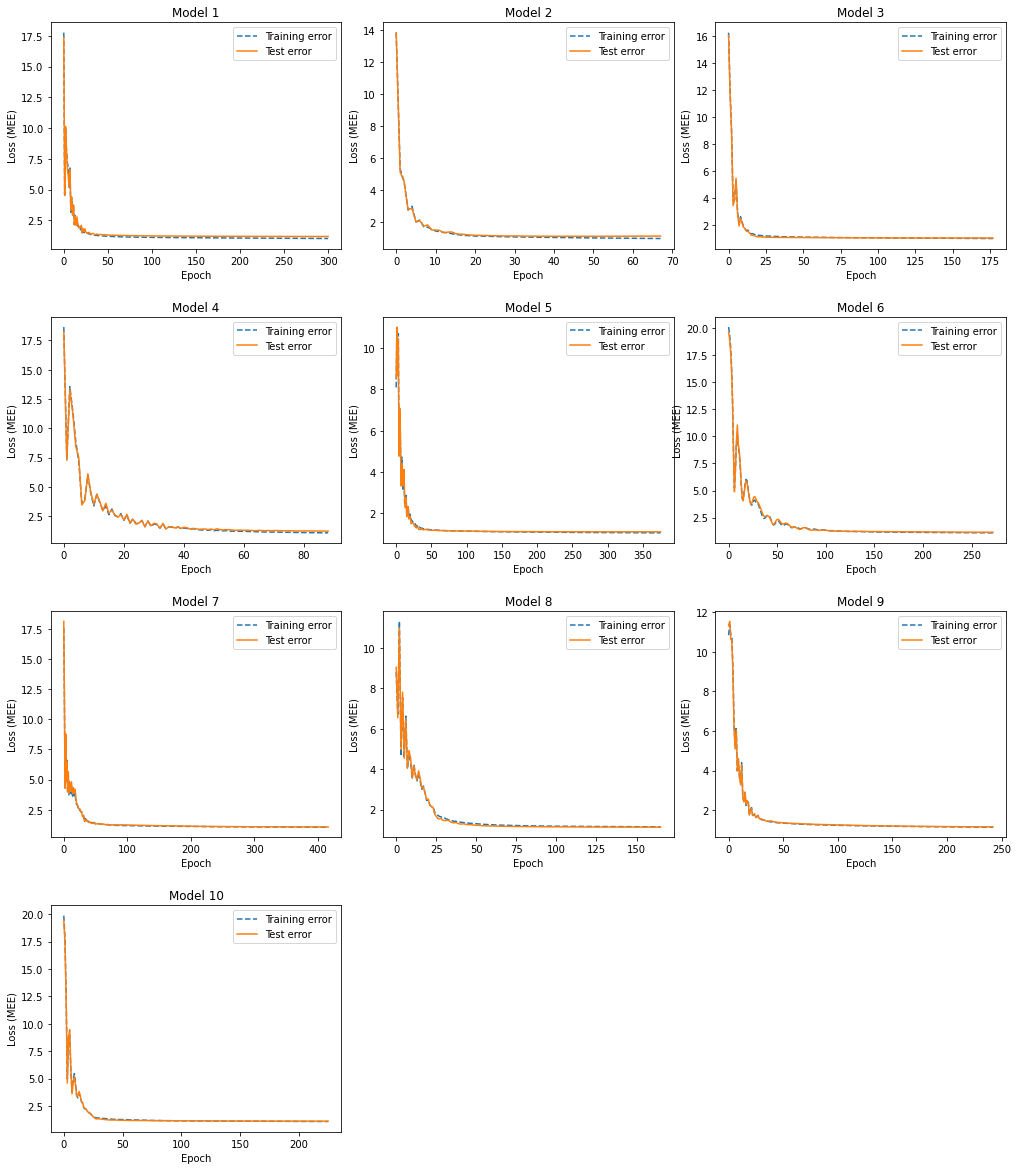

In [32]:
fig, axes = plt.subplots(4, 3, figsize=(14,16))
axes = axes.flatten()
fig.tight_layout()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    loss_train = loss_train_best_models[i]
    loss_test = loss_test_best_models[i]
    plot_learning_curves(loss_train, loss_test, epochs, "Loss (MEE)", axes[i], i)

fig.subplots_adjust(hspace=0.3)
fig.delaxes(axes[10])
fig.delaxes(axes[11])

In [33]:
### Predicted points on internal test set

In [34]:
y_pred_voting_ens_train_test = np.average(y_predictions_train, axis=0)
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

print(f"MEE: {mee(y_test, y_pred_voting_ens_internal_test)}")

MEE: 1.0648335010014676


In [35]:
plot_coordinates(y_predicted_test, y_test)

NameError: name 'y_predicted_test' is not defined

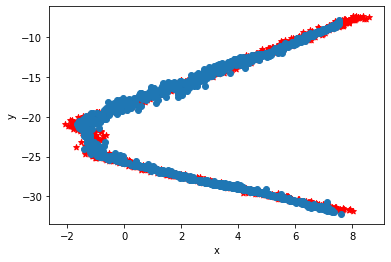

In [ ]:
plot_coordinates(y_predicted, y)

### Predicted points on blind test set

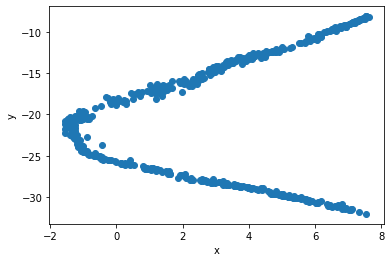

In [ ]:
plot_coordinates(y_predicted_blind)

## Ensemble 

Then we try the voting method using the 10 best models from the randomized search. 

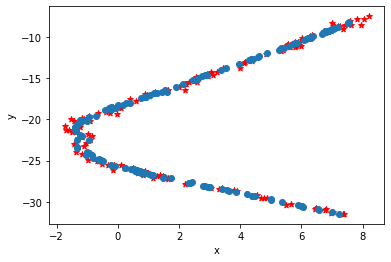

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

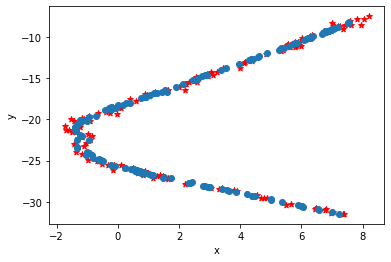

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

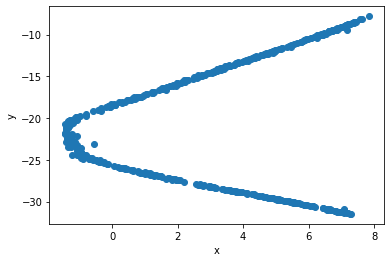

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_blind_test, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>